# Tuning Algorithms

In [128]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import load_model

from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

import joblib


In [106]:
#X_train = pd.read_csv('data/xtrainfs.csv') #check the validity of feature selection
X_train = pd.read_csv('data/ClassBalanced/xtrain.csv')
y_train_label = pd.read_csv('data/ClassBalanced/ytrain.csv')

#X_test = pd.read_csv('data/xtestfs.csv') #check the validity of feature selection
X_test = pd.read_csv('data/xtest.csv')
y_test_label = pd.read_csv('data/ytest.csv')

y_train = LabelEncoder().fit_transform(y_train_label)
y_train = y_train.astype(int)


y_test = LabelEncoder().fit_transform(y_test_label)
y_test = y_test.astype(int)

/home/fabio/.venv/myproj/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [146]:
X_train

,u,g,r,i,z,redshift
0,17.438960,15.984720,15.453350,15.283440,15.218250,-0.000018
1,19.148680,18.089840,17.594960,17.226680,17.007590,0.139176
2,19.131310,18.034590,17.522060,17.185050,17.020530,0.089176
3,19.827890,18.759740,18.375290,18.241360,18.183950,-0.000074
4,20.657190,19.146510,20.994190,29.889210,27.805190,0.144278
...,...,...,...,...,...,...
119320,18.471756,18.854495,19.328720,19.707208,20.027654,-0.003510
119321,18.278332,17.320393,17.029509,16.939980,16.922169,0.000365
119322,24.200051,21.840844,21.518598,21.268502,21.067801,-0.000639
119323,22.045105,20.739304,20.076229,19.783065,19.701208,-0.000279


## XGBoost Tuning

In [94]:
%%time
import numpy as np
import pandas as pd   
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

def random_search_tuning(x, y):
    # Input data files are available in the "./data/" directory.

    # define the train set and test set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=1000)

    param_grid = {
              'alpha': [0.1, 0.2, 0.3],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.5, 1.0, 0.1),
              #'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
              #'n_estimators': [100, 500, 750],
              #'num_class': [10]
              }

    #xgbclf = xgb.XGBClassifier(objective="multi:softmax", tree_method='hist')
    model = XGBClassifier()
    rsearch = RandomizedSearchCV(estimator=model,
                             param_distributions=param_grid,
                             scoring='accuracy',
                             n_iter=25,
                             random_state=1000,
                             verbose=1)

    rsearch.fit(x_train, y_train)

    best_combination = rsearch.best_params_

    return best_combination

best_params = random_search_tuning(X_train.values, y_train)

print("Best hyperparameter combination: ", best_params)
print("Done")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameter combination:  {'subsample': 0.5, 'learning_rate': 0.3, 'colsample_bytree': 0.8999999999999999, 'alpha': 0.1}
Done
CPU times: user 2h 49min 48s, sys: 4.9 s, total: 2h 49min 53s
Wall time: 10min 37s


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19670
           1       0.93      0.95      0.94      6200
           2       1.00      1.00      1.00      7130

    accuracy                           0.98     33000
   macro avg       0.97      0.97      0.97     33000
weighted avg       0.98      0.98      0.98     33000

0.9757878787878788


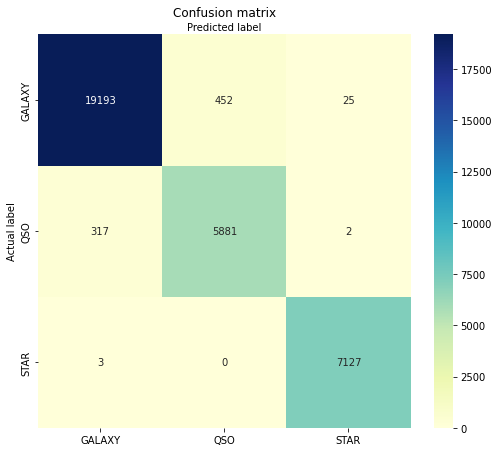

MCC:  0.9571591507967054


In [96]:
XGB = XGBClassifier(subsample=0.5, learning_rate=0.3, colsample_bytree=0.9, alpha=0.1)
XGB.fit(X_train.values,y_train)
XGB_predicted = XGB.predict(X_test)#X_test

report = classification_report(y_test, XGB_predicted)#Y_test
print(report)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, XGB_predicted))
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, XGB_predicted)# Y_test

# Create heatmap from the confusion matrix
class_names=['GALAXY', 'QSO', 'STAR'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5, 2.5]
plt.yticks(tick_marks, class_names)
plt.xticks(tick_marks, class_names)
plt.savefig('data/xgbconfusion.png')
plt.show()
print('MCC: ', matthews_corrcoef(y_test, XGB_predicted))


## No XGB Tuning for comparison

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19670
           1       0.93      0.95      0.94      6200
           2       1.00      1.00      1.00      7130

    accuracy                           0.98     33000
   macro avg       0.97      0.97      0.97     33000
weighted avg       0.98      0.98      0.98     33000

0.9753030303030303


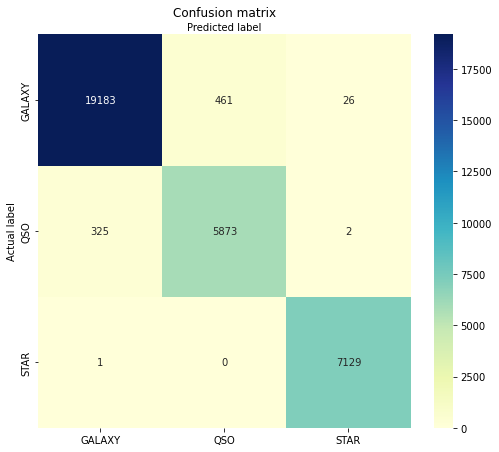

MCC:  0.9563056612751344


In [97]:

#XGB_tuned.fit(X, Y)
XGB_default = XGBClassifier()
XGB_default.fit(X_train.values,y_train)
XGB_predicted2 = XGB_default.predict(X_test)#X_test

report = classification_report(y_test, XGB_predicted2)#Y_test
print(report)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, XGB_predicted2))
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, XGB_predicted2)# Y_test

# Create heatmap from the confusion matrix
class_names=['GALAXY', 'QSO', 'STAR'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5, 2.5]
plt.yticks(tick_marks, class_names)
plt.xticks(tick_marks, class_names)
plt.show()
print('MCC: ', matthews_corrcoef(y_test, XGB_predicted2))

In [ ]:
# try and see how kaggler got such a higher score on the test
# never balance the test set!

## Compare to Logistic Regression

/home/fabio/.venv/myproj/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.92      0.95     19670
           1       0.86      0.93      0.89      6200
           2       0.91      1.00      0.95      7130

    accuracy                           0.94     33000
   macro avg       0.92      0.95      0.93     33000
weighted avg       0.94      0.94      0.94     33000

0.9382727272727273


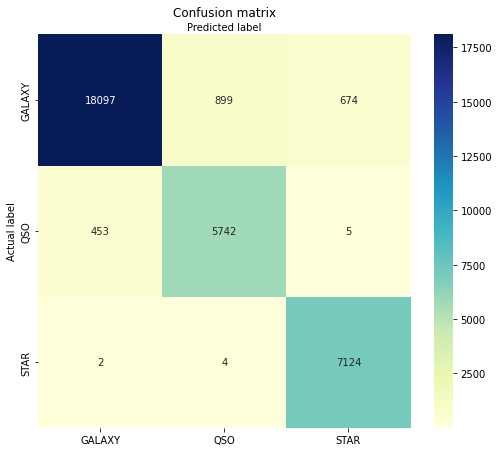

MCC:  0.8943940279393972


In [98]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train.values,y_train)
logreg_predicted = logreg.predict(X_test)#X_test

report_lr = classification_report(y_test, logreg_predicted)#Y_test
print(report_lr)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, logreg_predicted))
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, logreg_predicted)# Y_test

# Create heatmap from the confusion matrix
class_names=['GALAXY', 'QSO', 'STAR'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5, 2.5]
plt.yticks(tick_marks, class_names)
plt.xticks(tick_marks, class_names)
plt.savefig('data/xgbconfusion.png')
plt.show()
print('MCC: ', matthews_corrcoef(y_test, logreg_predicted))


## Hyperparameter tune RFC

In [131]:
%%time


def random_search_tuning(x, y):
   
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=1000)

    param_grid = {
        'n_estimators': [500, 1000],
        'max_features': ["sqrt", "log2"]
    }

    model = RandomForestClassifier()
    rsearch = RandomizedSearchCV(estimator=model,
                             param_distributions=param_grid,
                             scoring='accuracy',
                             random_state=1000,
                             verbose=1)
    """

# Using the random grid and searching for best hyperparameters

rf = RandomForestRegressor() #creating base model

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    
    """

    rsearch.fit(x_train, y_train)

    best_combination = rsearch.best_params_

    return best_combination

best_params = random_search_tuning(X_train.values, y_train)

print("Best hyperparameter combination: ", best_params)
print("Done")


/home/fabio/.venv/myproj/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best hyperparameter combination:  {'n_estimators': 1000, 'max_features': 'sqrt'}
Done
CPU times: user 27min 48s, sys: 899 ms, total: 27min 49s
Wall time: 27min 49s


/home/fabio/.venv/myproj/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19670
           1       0.94      0.95      0.94      6200
           2       1.00      1.00      1.00      7130

    accuracy                           0.98     33000
   macro avg       0.97      0.98      0.97     33000
weighted avg       0.98      0.98      0.98     33000

0.9777575757575757


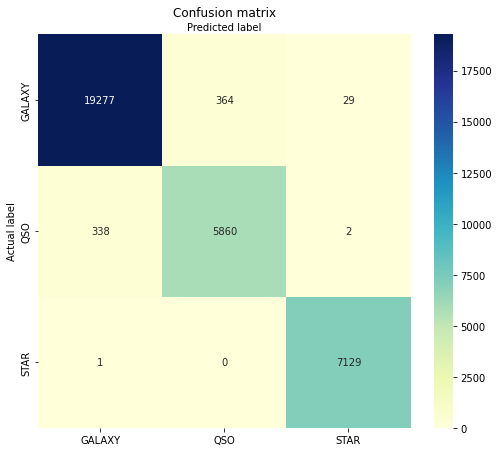

MCC:  0.9605232762117636
CPU times: user 3min 36s, sys: 200 ms, total: 3min 36s
Wall time: 3min 36s


In [133]:
%%time
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion='gini')# was gini before
rfc.fit(X_train.values,y_train)
rfc_pred = rfc.predict(X_test)#X_test

report_rf = classification_report(y_test, rfc_pred)#Y_test
print(report_rf)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, rfc_pred))
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_pred)# Y_test

# Create heatmap from the confusion matrix
class_names=['GALAXY', 'QSO', 'STAR'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5, 2.5]
plt.yticks(tick_marks, class_names)
plt.xticks(tick_marks, class_names)
#plt.savefig('data/xgbconfusion.png')
plt.show()
print('MCC: ', matthews_corrcoef(y_test, rfc_pred))
# using just the top 3 features helps!!! Even better with all features without pca
# 97.8% with no feature selection#

## RFC without tuning for comparison

/home/fabio/.venv/myproj/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19670
           1       0.94      0.94      0.94      6200
           2       1.00      1.00      1.00      7130

    accuracy                           0.98     33000
   macro avg       0.97      0.97      0.97     33000
weighted avg       0.98      0.98      0.98     33000

0.9774242424242424


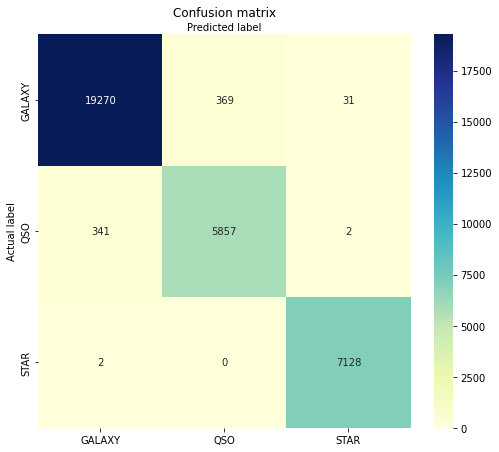

MCC:  0.9599346362635538
CPU times: user 21.9 s, sys: 170 ms, total: 22.1 s
Wall time: 21.9 s


In [127]:
%%time
from sklearn.ensemble import RandomForestClassifier

#select=['redshift', ']

rfc2 = RandomForestClassifier()
rfc2.fit(X_train.values,y_train)
rfc_pred2 = rfc.predict(X_test)#X_test

report_rf = classification_report(y_test, rfc_pred2)#Y_test
print(report_rf)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, rfc_pred2))
# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, rfc_pred)# Y_test

# Create heatmap from the confusion matrix
class_names=['GALAXY', 'QSO', 'STAR'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5, 2.5]
plt.yticks(tick_marks, class_names)
plt.xticks(tick_marks, class_names)
#plt.savefig('data/xgbconfusion.png')
plt.show()
print('MCC: ', matthews_corrcoef(y_test, rfc_pred))
# using just the top 3 features helps!!! Even better with all features without pca
# 97.7% with no feature selection#

In [160]:
joblib.dump(rfc, "./random_forest.joblib", compress=3)

['./random_forest.joblib']

In [143]:
pd.DataFrame(rfc_pred)

,0
0,0
1,2
2,0
3,0
4,0
...,...
32995,0
32996,0
32997,0
32998,0


0    59391
2    21624
1    18985
dtype: int64
